# Set up analysis
Defines functions used for analysis.

In [46]:
# Load modules
import datacube
import fiona
import glob
import itertools
import os
import rasterio
import warnings
import pandas as pd
import rasterio.features
import xarray as xr
import numpy as np
from collections import OrderedDict
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_invalid_data
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from matplotlib import pyplot as plt
from osgeo import gdal
from os.path import splitext
from shapely.geometry import Point
from shapely.geometry import shape
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn.tree import export_graphviz
from sklearn.tree import _tree 

# For nicer notebook plotting, hide warnings (comment out for real analysis)
warnings.filterwarnings('ignore') 

# Set up datacube instance
dc = datacube.Datacube(app = 'Random forest classification')


def load_nbart(sensor, query):
    
    '''
    Loads nbart data for a sensor, mask by pq and filter terrain -999s.
    Modified from original function written by B Dunn (2017).
    
    :attr sensor: Landsat sensor to import (valid options: 'ls5', 'ls7', 'ls8')
    :attr query: complete datacube query used to import data
    
    :returns: xarray dataset matching query
    '''  
    
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('Loading {}'.format(product_name))
    ds = dc.load(product = product_name,
                 group_by = 'solar_day', 
                 **query)
    
    if ds:       
   
        print('Loaded {}'.format(product_name))
        
        # Extract PQ data for masking
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product = mask_product, 
                            fuse_func = ga_pq_fuser,
                            group_by = 'solar_day', 
                            **query)
        
        if sensor_pq:
            
            print('Making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca = 'no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask = 'no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous = True)
            
            # Filter to remove clouds and -999 terrain issues
            ds = ds.where(cloud_free)
            ds = ds.where(ds != -999.0)
            
            # Add projection attributes
            ds.attrs['crs'] = ds.crs
            ds.attrs['affine'] = ds.affine    
            ds.attrs['geo_transform'] = ds.geobox.transform.to_gdal()
            ds.attrs['proj'] = ds.geobox.crs.wkt
            print('Masked {} with {} and filtered ' \
                  'terrain'.format(product_name, mask_product))
            
        else: 
            
            print('Did not mask {} with {}'.format(product_name, mask_product))
            
    else:
        
        print ('Did not load {}'.format(product_name)) 

    if len(ds) > 0:
        
        return ds
    
    else:
        
        return None


def rasterize_vector(input_data, cols, rows, geo_transform,
                     projection, field):
    
    """
    Rasterize a vector file and return numpy array
    
    :attr input_data: input shapefile path or preloaded GDAL/OGR layer
    :attr cols: width of output array in columns
    :attr rows: height of output array in rows
    :attr geo_transform: geotransform for rasterization
    :attr projection: projection for rasterization
    :attr field: shapefile field to take values from
    
    :returns: a 'row x col' array containg values from vector
    """
    
    # If input data is a string, import as shapefile layer
    if isinstance(input_data, str):    
    
        # Open vector with gdal
        data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
        input_data = data_source.GetLayer(0)
    
    # Set up output raster
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    
    # Rasterize shapefile and extract array
    gdal.RasterizeLayer(target_ds, [1], input_data, options=["ATTRIBUTE=" + field])
    band = target_ds.GetRasterBand(1)
    out_array = band.ReadAsArray()
    target_ds = None
    
    return out_array


def write_geotiff(fname, data, geo_transform, projection, nodata_val):
    
    """
    Create a single band GeoTIFF file with data from array.
    
    :attr fname: output file path
    :attr data: input array
    :attr geo_transform: geotransform for output raster
    :attr projection: projection for output raster
    :attr nodata_val: value to convert to nodata in output raster
    """
    
    # Set up driver
    driver = gdal.GetDriverByName('GTiff')
    
    # Create raster of given size and projection
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    
    # Write data to array and set nodata values
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    band.SetNoDataValue(nodata_val)
    
    # Close file
    dataset = None     
    

def tasseled_cap(sensor_data, sensor, tc_bands = ['greenness', 'brightness', 'wetness'], 
                 drop = True):
    
    """
    Computes tasseled cap wetness, greenness and brightness bands from a six
    band xarray dataset, and returns a new xarray dataset with old bands 
    optionally dropped
    
    :attr sensor_data: input xarray dataset with six Landsat bands
    :attr tc_bands: list of tasseled cap bands to compute 
    (valid options: 'wetness', 'greenness','brightness'
    :attr sensor: Landsat sensor used for coefficient values 
    (valid options: 'ls5', 'ls7', 'ls8')
    :attr drop: if 'drop = False', return all original Landsat bands 
    
    :returns: xarray dataset with newly computed tasseled cap bands
    """
    
    # Copy input dataset
    output_array = sensor_data.copy(deep = True)
 
    # Coefficients for each tasseled cap band
    wetness_coeff = {'ls5':{'blue':0.0315, 'green':0.2021, 'red':0.3102, 
                            'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109},
                     'ls7':{'blue':0.0315, 'green':0.2021, 'red':0.3102, 
                            'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109},
                     'ls8':{'blue':0.0315, 'green':0.2021, 'red':0.3102, 
                            'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109}}
    
    greenness_coeff = {'ls5':{'blue':-0.1603, 'green':-0.2819, 'red':-0.4934, 
                              'nir':0.7940, 'swir1':-0.0002, 'swir2':-0.1446},
                       'ls7':{'blue':-0.1603, 'green':-0.2819, 'red':-0.4934, 
                              'nir':0.7940, 'swir1':-0.0002, 'swir2':-0.1446},
                       'ls8':{'blue':-0.1603, 'green':-0.2819, 'red':-0.4934, 
                              'nir':0.7940, 'swir1':-0.0002, 'swir2':-0.1446}}
    
    brightness_coeff = {'ls5':{'blue':0.2043, 'green':0.4158, 'red':0.5524, 
                               'nir':0.5741, 'swir1':0.3124, 'swir2':0.2303},
                        'ls7':{'blue':0.2043, 'green':0.4158, 'red':0.5524, 
                               'nir':0.5741, 'swir1':0.3124, 'swir2':0.2303},
                        'ls8':{'blue':0.2043, 'green':0.4158, 'red':0.5524, 
                               'nir':0.5741, 'swir1':0.3124, 'swir2':0.2303}}
    
    # Dict to use correct coefficients for each tasseled cap band
    analysis_coefficient = {'wetness': wetness_coeff, 
                            'greenness': greenness_coeff,
                            'brightness': brightness_coeff}
    
    # For each band, compute tasseled cap band and add to output dataset
    for tc_band in tc_bands:

        # Create xarray of coefficient values used to multiply each band of input
        coeff = xr.Dataset(analysis_coefficient[tc_band][sensor])    
        sensor_coeff = sensor_data * coeff

        # Sum all bands
        output_array[tc_band] = sensor_coeff.blue + sensor_coeff.green + \
                                sensor_coeff.red + sensor_coeff.nir + \
                                sensor_coeff.swir1 + sensor_coeff.swir2
    
    # If drop = True, remove original bands
    if drop:
        
        bands_to_drop = list(sensor_data.data_vars)        
        output_array = output_array.drop(bands_to_drop)        

    return(output_array)


def point_in_poly(lon, lat, field, shapefile):
    
    """
    Extract data from polygon that contains point
    
    :attr lon: x coordinate of point
    :attr lat: y coordinate of point
    :attr field: field of polygon shapefile to extract for matching points
    :attr shapefile: polygon shapefile to import
    
    :returns: if point falls within polygon, return field from polygon
    """

    # Convert coordinates to shapely point
    mypoint = Point(lon, lat)   

    # Extract polygon info
    with fiona.open(shapefile) as shp:

        # For each polygon, identify if point falls within polygon
        poly_idx = [poly['properties'][field] for i, poly in enumerate(shp)
                    if mypoint.within(shape(poly['geometry']))]

    # If point is within polygon
    if poly_idx:
        
        # Take first polygon to avoid multiple matches        
        return(poly_idx[0])

    # If point not found in any polygon, return none
    else: 
        
        return None


def layer_extent(layer):
    
    """
    Computes min and max extents for GDAL layer features. Compared to
    built-in ".GetExtent" that always returns unfiltered extents, this 
    allows you to compute extents of features within filtered layers 
    (e.g. layers filtered with 'SetAttributeFilter')
    """
    
    # Extract tuples of x, y, z coordinates for each point feature
    point_coords = [feature.geometry().GetPoint() for feature in layer]
    
    # Compute mins and maxes across points for each tuple element
    max_x, max_y, max_z = map(min, zip(*point_coords))
    min_x, min_y, min_z = map(max, zip(*point_coords))    
    
    return  min_x, max_x, min_y, max_y


def randomforest_train(train_shps, train_field, data_func, data_func_params = {},
                       classifier_params = {}, train_reclass = None):
    
    '''
    Extracts training data from xarray dataset for multiple training shapefiles.
    Loops through each each training shapefile, calling dc.load on extent of file.
    
    :attr train_shps: list of training shapefile paths to import. Each file 
    should cover a small enough spatial area so as to not slow dc.load function 
    excessively (e.g. 100 x 100km max)
    :attr train_field: shapefile field containing classification class
    :attr data_func: function to import xarray data for each shapefile. Should return 
    an xarray dataset with 'geo_transform' and 'proj' attributes
    :attr data_func_params: optional dict of dc.load query inputs. Useful for defining 
    time query for temporal datasets (spatial queries are set automatically from shapefiles)
    :attr classifier_params: optional dict of parameters for training random forest
    :attr train_reclass: optional dict of from:to pairs to reclassify classification classes 
    in shapefile field. Useful for simplifying multiple classes into a simpler set of classes
    
    :returns: trained classifier
    :returns: array of training labels
    :returns: array of training data
    '''

    # Output training label and pixel arrays
    training_labels_list = list()
    training_samples_list = list()

    # For each shapefile, extract datacube data using extent of points
    # and add resulting spectral data and labels to list of arrays
    for train_shp in train_shps:
        
        print("Importing training data from {}:".format(train_shp))
        
        try:

            # Open vector of training points with gdal
            data_source = gdal.OpenEx(train_shp, gdal.OF_VECTOR)
            layer = data_source.GetLayer(0)      

            # Compute extents and generate spatial query
            xmin, xmax, ymin, ymax = layer_extent(layer) 
            query_train = {'x': (xmin + 500, xmax - 500),
                           'y': (ymin + 500, ymax - 500),
                           'crs': 'EPSG:3577',
                           **data_func_params}        
            print(query_train)

            # Import data  as xarray and extract projection/transform data
            training_xarray = data_func(query_train)
            geo_transform_train = training_xarray.geo_transform
            proj_train = training_xarray.proj 

            # Covert to array and rearrange dimension order
            bands_array_train = training_xarray.to_array().values
            bands_array_train = np.einsum('bxy->xyb', bands_array_train)
            rows_train, cols_train, bands_n_train = bands_array_train.shape

            # Import training data shapefiles and convert to matching raster pixels
            training_shapefile = train_shp
            training_pixels = rasterize_vector(layer, cols_train, rows_train, 
                                               geo_transform_train, proj_train, 
                                               field = train_field)  

            # Extract matching image sample data for each labelled pixel location
            is_train = np.nonzero(training_pixels)
            training_labels = training_pixels[is_train]
            training_samples = bands_array_train[is_train]

            # Remove nans from training samples
            training_labels = training_labels[~np.isnan(training_samples).any(axis=1)]
            training_samples = training_samples[~np.isnan(training_samples).any(axis=1)]

            # Append outputs
            training_labels_list.append(training_labels)
            training_samples_list.append(training_samples)
        
        except AttributeError:
            
            print("  Skipping training data from {}; check file path is correct".format(train_shp))

    # Combine polygon training data    
    training_labels = np.concatenate(training_labels_list, axis=0)
    training_samples = np.concatenate(training_samples_list, axis=0)  
    
    # Optionally reclass values prior to classification training
    if train_reclass:
        
        # For each class in training labels, convert to new values using train_reclass
        training_labels[:] = [train_reclass[label] for label in training_labels]
    
    # Set up classifier and train on training sample data and labels
    # Options for tuning: https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
    print("\nTraining random forest classifier...")
    classifier = RandomForestClassifier(**classifier_params) 
    classifier.fit(training_samples, training_labels)
    print("Model trained on {0} bands and "
          "{1} training samples".format(training_samples.shape[1],
                                        str(len(training_samples))))
    
    return classifier, training_labels, training_samples


def randomforest_classify(classifier, analysis_data, classification_output, class_prob = False):
    
    '''
    Performs classification of xarray dataset using pre-trained random forest classifier, 
    and export classified output to a geotiff. Optionally, also export a predicted class 
    probability raster (i.e. indicating fraction of samples of the predicted class in a leaf)
    
    :attr classifier: random forest classifier generated using randomforest_train
    :attr analysis_data: xarray dataset with 'geo_transform' and 'proj' attributes
    and the same number of bands as data used to train classifier
    :attr classification_output: file path to output geotiff classification 
    :attr class_prob: if True, compute predicted class probability and export to 
    geotiff suffixed with "_prob.tif"
    '''

    geo_transform = analysis_data.geo_transform
    proj = analysis_data.proj 

    # Covert to array and rearrange dimension order
    analysis_array = analysis_data.to_array().values
    analysis_array = np.einsum('bxy->xyb', analysis_array)
    rows, cols, bands_n = analysis_array.shape
    print("Data to classify:\n  Rows: {0}\n  Columns: {1}\n  Bands: {2}".format(rows, cols, bands_n))

    # Remove nodata and return flattened 'pixel x bands' array
    input_nodata = np.isnan(analysis_array).any(axis = 2)
    flat_pixels = analysis_array[~input_nodata]

    # Run classification
    print("\nClassification processing...")
    result = classifier.predict(flat_pixels)

    # Restore 2D array by assigning flattened output to empty array
    classification = np.zeros((rows, cols))
    classification[~input_nodata] = result

    # Nodata removed
    print("  {} nodata cells removed".format(str(np.sum(classification == 0))))

    # Export to file
    write_geotiff(classification_output, 
                  data = classification, 
                  geo_transform = geo_transform, 
                  projection = proj,
                  nodata_val = 0)
    print("  Classification exported")  
    
    # If requested, export classification probability:
    if class_prob:    
    
        # Compute predicted class probability (fraction of samples of same class in a leaf)
        # Use max to return only highest probability (the one that determined output class)
        print("\nClass probability processing...")
        result_prob = classifier.predict_proba((flat_pixels))
        result_prob = np.max(result_prob, axis = 1) * 100.0 

        # Restore 2D array by assigning flattened output to empty array
        classification_prob = np.zeros((rows, cols))
        classification_prob[~input_nodata] = result_prob

        # Export to file
        write_geotiff(splitext(classification_output)[0] + "_prob.tif", 
                      data = classification_prob, 
                      geo_transform = geo_transform, 
                      projection = proj,
                      nodata_val = -999)
        print("  Class probability exported")

    
def randomforest_eval(training_labels, training_samples, classifier_scenario, 
                      output_path, max_estimators = 100):
    
    """
    Takes a set of training labels and training samples, and plots OOB error against
    a range of classifier parameters to explore how parameters affect classification.
    
    :attr training_labels: an (X, ) array of training labels
    :attr training_samples: an (X, B) array of training sample data
    :attr classifier_scenario: dict of classifier scenarios to plot
    :attr output_path: output path for plot of OOB error by scenario
    :attr max_estimators: max number of estimators to plot on x-axis (default = 100)
    """

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in classifier_scenario)

    # Range of `n_estimators` values to explore.
    min_estimators = 1

    for label, clf in classifier_scenario:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators = i)
            clf.fit(train_samp, train_lab)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label = label)

    # Plot and save output as figure
    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc = "upper right")
    plt.savefig(output_path, bbox_inches = 'tight')
    plt.show()


# List of training files to import. Each file should cover a small enough spatial area 
# so as to not slow dc.load function excessively (e.g. 100 x 100km max)
train_shps = ["raw_data/train/training_data_mangrove.shp",
              "raw_data/train/training_data_mangrove1.shp",
              "raw_data/train/training_data_mangrove2.shp"]
# train_shps = ["raw_data/train/training_data_tasseledcap.shp"]
    
# Classification output path
classification_output = "output_data/classification_dc_mangrove.tif"
# classification_output = "output_data/classification_dc_tasseledcap.tif"

# Output class names
classification_names = ["mangrove", "other"]
# classification_names = ["mangrove", "water", "veg", "other"]
# classification_names = ["swamp", "escarpment", "plateau", "ephem_swamp"]


# Functions used to import training and analysis data
Both of these functions import datacube data using a query, and return an xarray dataset with multiple bands/variables and 'geo_transform' and 'proj' attributes. 
This format is required as an input to both randomforest_train and randomforest_classify, and ensures that both training and analysis data are consistent.

In [31]:
def hltc_import(query):
    
    """
    Imports high and low composite data for a given spatial query, and
    return an xarray dataset with 'geo_transform' and 'proj' attributes 
    
    :attr query: spatial query for datacube.load()
    :returns: xarray dataset with 'geo_transform' and 'proj' attributes
    """

    # Import data
    low_tide = dc.load(product = 'low_tide_comp_20p', **query)
    high_tide = dc.load(product = 'high_tide_comp_20p', **query)

    # Rename variables in each high/low composite so datasets can be merged
    data_vars = list(low_tide.keys())[3:]  # select only data vars, not coords
    low_tide.rename({var: "lt_" + var for var in data_vars}, inplace = True)
    high_tide.rename({var: "ht_" + var for var in data_vars}, inplace = True)

    # Combine into one dataset
    output_xarray = xr.auto_combine([low_tide, high_tide]).isel(time = 0)
    
    # Set attributes   
    output_xarray.attrs['proj'] = low_tide.geobox.crs.wkt
    output_xarray.attrs['geo_transform'] = low_tide.geobox.transform.to_gdal()    
    
    return output_xarray


def tc_import(query):
    
    '''
    Wrapper around load_nbart and tasseled cap to return an xarray dataset with 
    'geo_transform' and 'proj' attributes
    
    :attr query: query for datacube call; for training, supply only
    non-spatial queries as spatial are generated from training data
    :returns: xarray dataset with 'geo_transform' and 'proj' attributes
    '''
    
    # Import cleaned Landsat bands data
    nbar_example = load_nbart('ls8', query)
    
    # Compute tasseled cap indices and take median of multiple timesteps
    output_xarray = tasseled_cap(sensor_data = nbar_example, 
                                 sensor = 'ls8',
                                 drop = True).median("time", keep_attrs = True)
    
    return output_xarray        
    

# Import training data and fit model
Uses randomforest_train to extract training data from potentially multiple training shapefiles, and returns a trained classifier (and optionally, training label and training sample arrays)

In [47]:
# Dict of classifier parameters
classifier_params = {'n_jobs': -1,                                    
                     'n_estimators': 100,
                     'max_features': "auto",
                     'min_samples_leaf': 2,
                     'oob_score': True }

# Optional time query parameters (used for temporal datasets)
data_func_params = {}
# data_func_params = {'time': ('2017-03-01', '2017-06-28')}

# Extract training data for each training shapefile and train classifier
classifier, _, _ = randomforest_train(train_shps = train_shps,
                                      train_field = "class",
                                      data_func = hltc_import, # tc_import, #   
                                      data_func_params = data_func_params,
                                      classifier_params = classifier_params,
                                      train_reclass = {1:1, 2:2, 3:2, 4:2})


Importing training data from raw_data/train/training_data_mangrove.shp:
{'x': (-97695.37617727809, -157527.5762163046), 'y': (-1295246.4245350992, -1347639.5474466463), 'crs': 'EPSG:3577'}
Importing training data from hello:
  Skipping training data from hello; check file path is correct
Importing training data from raw_data/train/training_data_mangrove1.shp:
{'x': (-250322.2628674942, -267715.4139100249), 'y': (-1572014.9681683218, -1589491.9822624666), 'crs': 'EPSG:3577'}
Importing training data from raw_data/train/training_data_mangrove2.shp:
{'x': (-218270.8137106544, -236105.05985552695), 'y': (-1631968.8744477245, -1644765.5913745423), 'crs': 'EPSG:3577'}

Training random forest classifier...
Model trained on 12 bands and 305 training samples


# Import analysis data and classify
Classifies and exports an analysis dataset using a previously trained random forest classifier, provided this dataset has the same number of bands/variables as the data used to train the classifier. Using the same data function (e.g. tc_import, hltc_import) used to train the classifier will ensure this is the case. By setting 'class_prob = True', can optionally export a geotiff of predicted class probabilities in addition to classification output.

In [30]:
classification_output = "output_data/classification_dc_mangrove.tif"

# Set up analysis data query
lat_point, lon_point, buffer = -12.4600563815, 130.916985762, 40000
x, y = geometry.point(lon_point, lat_point, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),
         # 'time': ('2017-03-01', '2017-06-28'),
         'crs': 'EPSG:3577'}

# Load data from datacube
analysis_xarray = hltc_import(query)
# analysis_xarray = tc_import(query)

# Run classification and export to file   
randomforest_classify(classifier = classifier,
                      analysis_data = analysis_xarray,
                      classification_output = classification_output,
                      class_prob = True)


Data to classify:
  Rows: 3201
  Columns: 3200
  Bands: 12

Classification processing...
  0 nodata cells removed
  Classification exported

Class probability processing...
  Class probability exported


# Feature/band/variable importance
Extract classifier estimates of the relative importance of each band/variable for training the classifier. Useful for potentially selecting a subset of input bands/variables for model training/classification (i.e. optimising feature space)

,importance
variable,
lt_blue,0.032416
lt_green,0.020051
lt_red,0.020871
lt_nir,0.080693
lt_swir1,0.073684
lt_swir2,0.059442
ht_blue,0.007030
ht_green,0.013930
ht_red,0.016366


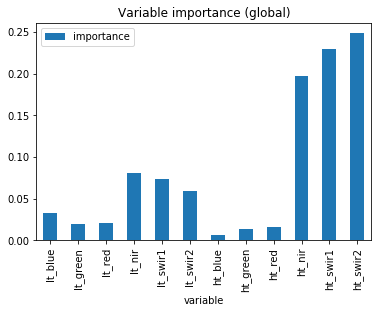

In [32]:
#  Extract feature importances from trained classifier
importance = classifier.feature_importances_
importance_df = pd.DataFrame({'variable': analysis_xarray.data_vars,
                              'importance': importance})
importance_df.set_index("variable", inplace = True)
importance_df.plot.bar(title = "Variable importance (global)")
display(importance_df)


# Export tree diagrams
Export .png plots of each decision tree in the random forest ensemble. Useful for inspecting the splits used by the classifier to classify the data.

In [33]:
# Plot output random forest trees to file
for n, tree_in_forest in enumerate(classifier.estimators_):

    # Create graph and save to dot file
    export_graphviz(tree_in_forest,
                    out_file = "figures/tree_graphs/tree.dot",
                    feature_names = list(analysis_xarray.data_vars),
                    class_names = classification_names,
                    filled = True,
                    rounded = True)

    # Plot as figure
    os.system('dot -Tpng figures/tree_graphs/tree.dot -o ' + \
              'figures/tree_graphs/tree' + str(n + 1) + '.png')    
    

# Plot performance of model by parameter values
Random forest classifiers contain many modifiable parameters that can strongly affect the performance of the model. This section evaluates the effect of these parameters by plotting out-of-bag (OOB) error for a set of classifier parameter scenarios, and exports the resulting plots to file.

Importing training data from raw_data/train/training_data_mangrove.shp:
{'x': (-97695.37617727809, -157527.5762163046), 'y': (-1295246.4245350992, -1347639.5474466463), 'crs': 'EPSG:3577'}
Importing training data from hello:
  Skipping training data from hello; check file path is correct
Importing training data from raw_data/train/training_data_mangrove1.shp:
{'x': (-250322.2628674942, -267715.4139100249), 'y': (-1572014.9681683218, -1589491.9822624666), 'crs': 'EPSG:3577'}
Importing training data from raw_data/train/training_data_mangrove2.shp:
{'x': (-218270.8137106544, -236105.05985552695), 'y': (-1631968.8744477245, -1644765.5913745423), 'crs': 'EPSG:3577'}

Training random forest classifier...
Model trained on 12 bands and 305 training samples


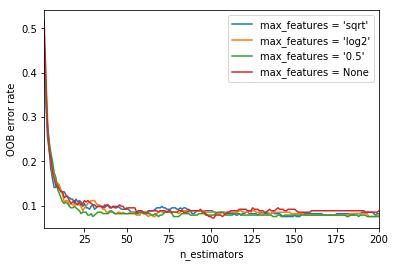

In [49]:
# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.

# Extract training data
_, train_lab, train_samp = randomforest_train(train_shps = train_shps,
                                              train_field = "class",
                                              data_func = hltc_import, #tc_import,
                                              data_func_params = {},
                                              classifier_params = classifier_params,
                                              train_reclass = {1:1, 2:2, 3:2, 4:2})

# Test effect of max features
classifier_scenario = [("max_features = 'sqrt'",
                        RandomForestClassifier(warm_start = True,
                                               oob_score = True,
                                               max_features = "sqrt")),
                       ("max_features = 'log2'",
                        RandomForestClassifier(warm_start = True, 
                                               oob_score = True,
                                               max_features = "log2")),
                       ("max_features = '0.5'",
                        RandomForestClassifier(warm_start = True, 
                                               max_features = 0.5,
                                               oob_score = True)),
                       ("max_features = None",
                        RandomForestClassifier(warm_start = True,
                                               max_features = None,
                                               oob_score = True))]

# # Test effect of minimum samples per leaf
# classifier_scenario = [("Leaf = 1",
#                       RandomForestClassifier(warm_start = True, 
#                                              min_samples_leaf = 1,
#                                              oob_score = True)),                       
#                        ("Leaf = 5",
#                         RandomForestClassifier(warm_start = True,
#                                                min_samples_leaf = 5,
#                                                oob_score = True)),                       
#                        ("Leaf = 20",
#                         RandomForestClassifier(warm_start = True, 
#                                                min_samples_leaf = 20,
#                                                oob_score = True))]

# # Test effect of max depth
# classifier_scenario = [("Max depth = 5",
#                       RandomForestClassifier(warm_start = True,
#                                              max_depth = 5,
#                                              oob_score = True)),                       
#                        ("Max depth = 10",
#                         RandomForestClassifier(warm_start = True,
#                                                max_depth = 10,
#                                                oob_score = True)),                       
#                        ("Max depth = 20",
#                         RandomForestClassifier(warm_start = True, 
#                                                max_depth = 20,
#                                                oob_score = True))]


# Plot OOB error by classifier scenario
randomforest_eval(training_labels = train_lab, 
                  training_samples = train_samp, 
                  classifier_scenario = classifier_scenario,
                  output_path = "figures/random_forest_params.png",
                  max_estimators = 200)


# Visualise random forest structure
Code to visualise internal structure of ensemble forest using histogram of leaf depths and number of samples.

Source: https://github.com/aysent/random-forest-leaf-visualization

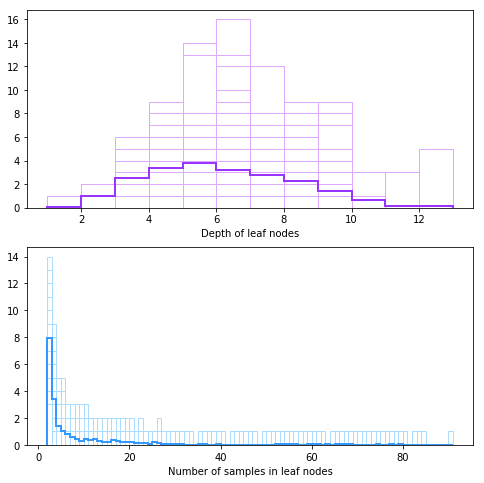

In [50]:
def leaf_depths(tree, node_id = 0):
    
     """
     tree.children_left and tree.children_right store ids
     of left and right chidren of a given node
     """
     left_child = tree.children_left[node_id]
     right_child = tree.children_right[node_id]

     """
     If a given node is terminal, 
     both left and right children are set to _tree.TREE_LEAF
     """
     if left_child == _tree.TREE_LEAF:
         
         '''
         Set depth of terminal nodes to 0
         '''
         depths = np.array([0])

     else:
         
         """
         Get depths of left and right children and
         increment them by 1
         """
         left_depths = leaf_depths(tree, left_child) + 1
         right_depths = leaf_depths(tree, right_child) + 1
 
         depths = np.append(left_depths, right_depths)
 
     return depths


def leaf_samples(tree, node_id = 0):
    
     left_child = tree.children_left[node_id]
     right_child = tree.children_right[node_id]

     if left_child == _tree.TREE_LEAF:
        
         samples = np.array([tree.n_node_samples[node_id]])

     else:
        
         left_samples = leaf_samples(tree, left_child)
         right_samples = leaf_samples(tree, right_child)

         samples = np.append(left_samples, right_samples)

     return samples


def draw_ensemble(ensemble):

     plt.figure(figsize=(8,8))
     plt.subplot(211)

     depths_all = np.array([], dtype=int)

     for x in ensemble.estimators_:
         tree = x.tree_
         depths = leaf_depths(tree)
         depths_all = np.append(depths_all, depths)
         plt.hist(depths, histtype='step', color='#ddaaff', 
                  bins=range(min(depths), max(depths)+1))

     plt.hist(depths_all, histtype='step', color='#9933ff', 
              bins=range(min(depths_all), max(depths_all)+1), 
              weights=np.ones(len(depths_all))/len(ensemble.estimators_), 
              linewidth=2)
     plt.xlabel("Depth of leaf nodes")
    
     samples_all = np.array([], dtype=int)
    
     plt.subplot(212)
    
     for x in ensemble.estimators_:
         tree = x.tree_
         samples = leaf_samples(tree)
         samples_all = np.append(samples_all, samples)
         plt.hist(samples, histtype='step', color='#aaddff', 
                  bins=range(min(samples), max(samples)+1))
    
     plt.hist(samples_all, histtype='step', color='#3399ff', 
              bins=range(min(samples_all), max(samples_all)+1), 
              weights=np.ones(len(samples_all))/len(ensemble.estimators_), 
              linewidth=2)
     plt.xlabel("Number of samples in leaf nodes")
    
     plt.show()
        
# Plot depth of leaf nodes and number of samples in leaf nodes        
draw_ensemble(classifier)

# Classification statistics (TBA)
Not currently working; will need method for incorperating validation data

In [ ]:
# # Verification data
# shapefiles = glob.glob(validation_data_path + "/*.shp")
# classes = [i.split("/")[2][0:1] for i in shapefiles]
# verification_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
# for_verification = np.nonzero(verification_pixels)
# verification_labels = verification_pixels[for_verification]
# predicted_labels = classification[for_verification]

# # Confusion matrix
# print("Confussion matrix:\n%s" %
#       metrics.confusion_matrix(verification_labels, predicted_labels))
# target_names = ['Class %s' % s for s in classes]

# # Per class report
# print("Classification report:\n%s" %
#       metrics.classification_report(verification_labels, predicted_labels,
#                                     target_names=target_names))

# # Overall classification accuracy
# print("Classification accuracy: %f" %
#       metrics.accuracy_score(verification_labels, predicted_labels))